In [ ]:
 # This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'backup'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# Change dariectory to current folder
%cd /content/drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/backup


In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
! pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.9 MB/s eta 0:00:00


In [ ]:
import sentencepiece as spm

de_vocab_file = 'de.model'
en_vocab_file = 'en.model'

de_vocab = spm.SentencePieceProcessor()
en_vocab = spm.SentencePieceProcessor()

# de, en vocab 로드
de_vocab.load(de_vocab_file)
en_vocab.load(en_vocab_file)

True

In [ ]:
import pandas as pd

train_df = pd.read_csv('train.csv')

In [ ]:
# data.py

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler

# mt Dataset
class MtDataset(Dataset):
  def __init__(self, src_vocab, trg_vocab, df, src_name, trg_name):
    self.src_vocab  = src_vocab
    self.trg_vocab = trg_vocab
    self.src_train = []
    self.trg_train = []

    for idx, row in df.iterrows():
      src_line = row[src_name]
      trg_line = row[trg_name]
      if type(src_line) != str or type(trg_line) != str:
        continue
      # src 문장, trg 문장 각각 tokenize
      self.src_train.append(src_vocab.encode_as_ids(src_line))
      self.trg_train.append(trg_vocab.encode_as_ids(trg_line))

  def __len__(self):
    assert len(self.src_train) == len(self.trg_train)
    return len(self.src_train)

  def __getitem__(self, idx):
    return (torch.tensor(self.src_train[idx]), torch.tensor(self.trg_train[idx]))


# mt data collate_fn
# 배치 단위로 데이터 처리
def mt_collate_fn(inputs):
  enc_inputs, dec_inputs = list(zip(*inputs)) # to do

  # 입력 길이가 다르므로 입력 최대 길이에 맟춰 padding(0) 추가
  enc_inputs = torch.nn.utils.rnn.pad_sequence(enc_inputs, batch_first=True)
  dec_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True)

  batch = [
      enc_inputs,
      dec_inputs
  ]

  return batch # DataLoader iterate 할 때 return됨


# DataLoader
def build_mt_data_loader(src_vocab, trg_vocab, df, src_name, trg_name, args, shuffle=True):
  # Dataset 생성
  dataset = MtDataset(src_vocab, trg_vocab, df, src_name, trg_name)
  if 1 < args['n_gpu'] and shuffle:
    sampler = DistributedSampler(dataset)
    loader = DataLoader(dataset, batch_size=args['batch_size'], sampler=sampler, collate_fn=mt_collate_fn)
  else:
    sampler = None
    loader = DataLoader(dataset, batch_size=args['batch_size'], sampler=sampler, shuffle=shuffle, collate_fn=mt_collate_fn)

  return loader, sampler

In [ ]:
tmp_config = {
    "n_gpu": 1, #tmp
    "batch_size": 256,
    "n_enc_vocab": 8000, # tmp
    "n_dec_vocab": 8000, # tmp
    "n_enc_seq": 80, # tmp
    "d_model": 512,
    "d_ff": 2048,
    "h": 8,
    "d_h": 64,
    "dropout": 0.1,
}

In [ ]:
args = {
    'n_gpu': tmp_config['n_gpu'],
    'batch_size': tmp_config['batch_size'],
}

loader, sampler = build_mt_data_loader(en_vocab, de_vocab, train_df, 'en', 'de', args)

In [ ]:
# Sinusoidal position representations
def get_sinusoidal(n_seq, d_model):
  '''
  Args:
      n_seq: sequence 길이 (=한 문장 내 토큰 개수)
      d_model: (=512)
  '''
  def cal_angle(i_seq, i_dmodel):
    return i_seq / np.power(10000, 2 * (i_dmodel // 2) / d_model)

  def get_pos_enc(i_seq):
    return [cal_angle(i_seq, i_dmodel) for i_dmodel in range(d_model)]

  pos_enc_table = np.array([get_pos_enc(i_seq) for i_seq in range(n_seq)])
  pos_enc_table[:, 0::2] = np.sin(pos_enc_table[:, 0::2]) # even idx
  pos_enc_table[:, 1::2] = np.cos(pos_enc_table[:, 1::2]) # odd idx

  return pos_enc_table

In [ ]:
class FFN(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.conv1 = nn.Conv1d(in_channels=self.config["d_model"], out_channels=self.config["d_ff"], kernel_size=1)
    self.conv2 = nn.Conv1d(in_channels=self.config["d_ff"], out_channels=self.config["d_model"], kernel_size=1)
    self.active = F.relu
    self.dropout = nn.Dropout(self.config["dropout"])

  # inputs: (batch_size, n_seq, d_model)
  def forward(self, inputs):
    # (batch_size, n_seq, d_model) -> (batch_size, d_model, n_seq) -> (batch_size, d_ff, n_seq)
    output = self.active(self.conv1(inputs.transpose(1,2)))
    # (batch_size, d_ff, n_seq) -> (batch_size, d_model, n_seq) -> (batch_size, n_seq, d_model)
    output = self.conv2(output).transpose(1,2)
    output = self.dropout(output)
    # output: (batch_size, n_seq, d_model)
    return output

In [ ]:
# attention pad mask
def get_attn_pad_mask(query, key, i_pad):
  '''
  Args:
      query: query(Q) (batch_size, 문장 내 토큰 개수)
      key: key(K) (batch_size, 문장 내 토큰 개수)
      * 전처리 했으므로 배치 내 토큰 개수 동일
      i_pad: padding 인덱스 (=0)
  '''
  batch_size, len_q = query.size()
  batch_size, len_k = key.size()
  # (batch_size, len_q, len_k)
  mask = key.data.eq(i_pad).unsqueeze(1).expand(batch_size, len_q, len_k)
  return mask


# attention decoder mask
def get_attn_decoder_mask(seq):
  '''
  Args:
      seq: (batch_size, 문장 내 토큰 개수)
  '''
  mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
  # (batch_size, len_seq, len_seq)
  mask = mask.triu(diagonal=1)
  return mask

In [ ]:
def returnExampleBatch():
  cnt = 0
  for [enc, dec] in loader:
   if (cnt < 1):
      return enc, dec
   else:
      break

example_q, example_k = returnExampleBatch()

In [ ]:
example_q

tensor([[  35,  732,  222,  ...,    0,    0,    0],
        [ 570,   47,  113,  ...,    0,    0,    0],
        [ 348,  106, 2127,  ...,    0,    0,    0],
        ...,
        [ 126,   78,   54,  ...,    0,    0,    0],
        [ 126,   35, 1837,  ...,    0,    0,    0],
        [1573,   31,   60,  ...,    0,    0,    0]])

In [ ]:
example_k

tensor([[ 145, 1779,  445,  ...,    0,    0,    0],
        [ 360,   95,  452,  ...,    0,    0,    0],
        [  95, 3851,  933,  ...,    0,    0,    0],
        ...,
        [ 426,   36,  136,  ...,    0,    0,    0],
        [ 118,   36, 3065,  ...,    0,    0,    0],
        [ 265, 1186,  651,  ...,    0,    0,    0]])

In [ ]:
example_pad_mask = get_attn_pad_mask(example_q, example_k, 0)

In [ ]:
example_pad_mask

tensor([[[False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         ...,
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True]],

        [[False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         ...,
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True]],

        [[False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         ...,
         [False, False, False,  ...,  True,  True,  True],
         [

In [ ]:
example_pad_mask.size()

torch.Size([256, 92, 100])

In [ ]:
example_decoder_mask = get_attn_decoder_mask(example_k)

In [ ]:
example_decoder_mask

tensor([[[0, 1, 1,  ..., 1, 1, 1],
         [0, 0, 1,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 0, 1, 1],
         [0, 0, 0,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 1, 1,  ..., 1, 1, 1],
         [0, 0, 1,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 0, 1, 1],
         [0, 0, 0,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 1, 1,  ..., 1, 1, 1],
         [0, 0, 1,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 0, 1, 1],
         [0, 0, 0,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 1, 1,  ..., 1, 1, 1],
         [0, 0, 1,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 0, 1, 1],
         [0, 0, 0,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 1, 1,  ..., 1, 1, 1],
         [0, 0, 1,  ..., 1, 1, 1],
         [0,

In [ ]:
example_decoder_mask.size()

torch.Size([256, 100, 100])

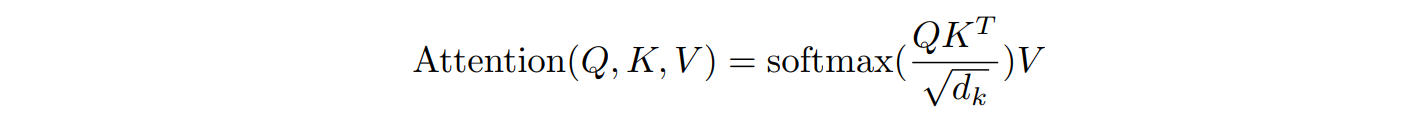

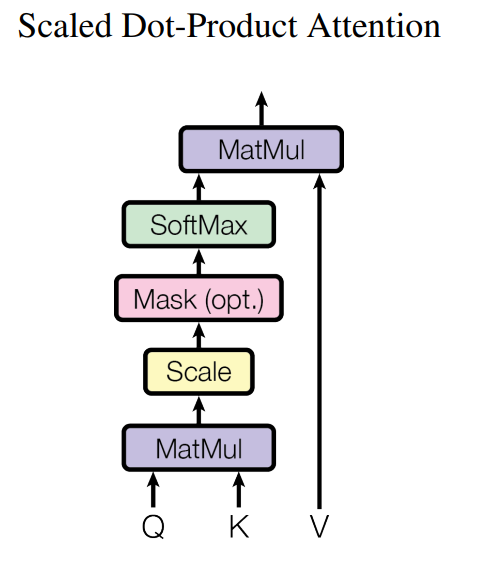

In [ ]:
class ScaledDotProductAttention(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config
    self.dropout = nn.Dropout(self.config["dropout"])
    self.scale = 1 / (self.config["d_h"] ** 0.5)

  def forward(self, Q, K, V, attn_mask):
    '''
    Args:
        Q: (batch_size, h, len_q, d_h)
        K: (batch_size, h, len_k, d_h)
        V: (batch_size, h, len_v, d_h)
        attn_mask: (batch_size, h, len_q, len_k)
    '''
    # (batch_size, h, len_q, len_k)
    affinities = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
    affinities.masked_fill_(attn_mask, -1e9)
    # (batch_size, h, len_q, len_k)
    attn_weights = nn.Softmax(dim=-1)(affinities)
    attn_weights = self.dropout(attn_weights)
    # (batch_size, h, len_q, d_h)
    output = torch.matmul(attn_weights, V)
    # (batch_size, h, len_q, d_h), (batch_size, h, len_q, len_k)
    return output, attn_weights

In [ ]:
ffn = FFN(tmp_config)
enc_emb = nn.Embedding(tmp_config["n_enc_vocab"], tmp_config["d_model"])

example_q = enc_emb(example_q)
example_k = enc_emb(example_k)

In [ ]:
example_q.size()

torch.Size([256, 92, 512])

In [ ]:
example_k.size()

torch.Size([256, 100, 512])

In [ ]:
# (d_model, h * d_h)
example_w_q = nn.Linear(tmp_config["d_model"], tmp_config["h"] * tmp_config["d_h"])

# (batch_size, len_q, d_model) * (d_model, h * d_h) = (batch_size, len_q, h * d_h)
example_q = example_w_q(example_q)

# (batch_size, len_q, h * d_h) -> (batch_size, h, len_q, d_h)
example_q = example_q.view(tmp_config["batch_size"], -1, tmp_config["h"], tmp_config["d_h"]).transpose(1, 2)

In [ ]:
example_q.size()

torch.Size([256, 8, 92, 64])

In [ ]:
example_pad_mask.size()

torch.Size([256, 92, 100])

In [ ]:
# (batch_size, len_q, len_k) -> (batch_size, h, len_q, len_k)

example_pad_mask = example_pad_mask.unsqueeze(1).repeat(1, tmp_config["h"], 1, 1)

In [ ]:
example_pad_mask.size()

torch.Size([256, 8, 92, 100])

In [ ]:
example_w_k = nn.Linear(tmp_config["d_model"], tmp_config["h"] * tmp_config["d_h"])
example_w_v = nn.Linear(tmp_config["d_model"], tmp_config["h"] * tmp_config["d_h"])

example_k = example_w_k(example_k)
example_v = example_w_v(example_k)

example_k = example_k.view(tmp_config["batch_size"], -1, tmp_config["h"], tmp_config["d_h"]).transpose(1, 2)
example_v = example_v.view(tmp_config["batch_size"], -1, tmp_config["h"], tmp_config["d_h"]).transpose(1, 2)

In [ ]:
example_k.size()

torch.Size([256, 8, 100, 64])

In [ ]:
example_v.size()

torch.Size([256, 8, 100, 64])

In [ ]:
example_scaled_dot_attn = ScaledDotProductAttention(tmp_config)

example_output, example_attn_weights = example_scaled_dot_attn(example_q, example_k, example_v, example_pad_mask)

In [ ]:
example_output.size()

torch.Size([256, 8, 92, 64])

In [ ]:
example_attn_weights.size()

torch.Size([256, 8, 92, 100])

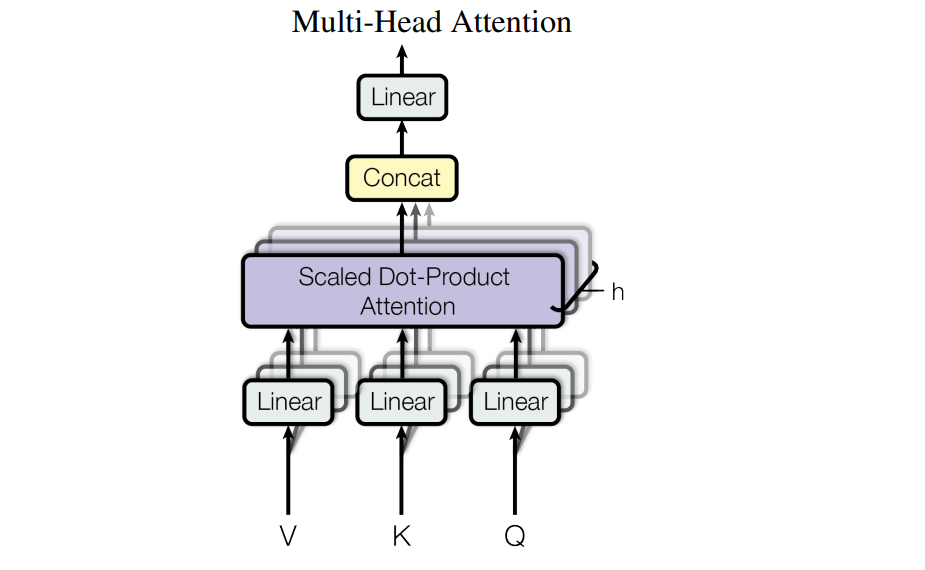

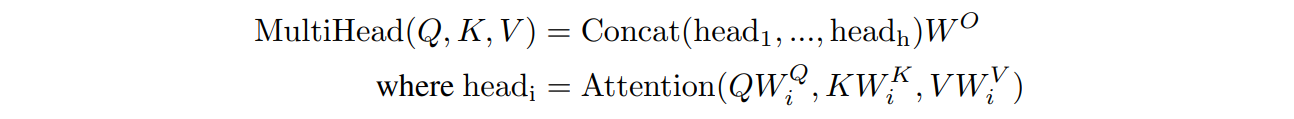

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config
    self.W_Q = nn.Linear(self.config['d_model'], self.config['h'] * self.config['d_h'])
    self.W_K = nn.Linear(self.config['d_model'], self.config['h'] * self.config['d_h'])
    self.W_V = nn.Linear(self.config['d_model'], self.config['h'] * self.config['d_h'])
    self.scaled_dot_attn = ScaledDotProductAttention(self.config)
    self.linear = nn.Linear(self.config['h'] * self.config['d_h'], self.config['d_model'])
    self.dropout = nn.Dropout(self.config['dropout'])

  def forward(self, Q, K, V, attn_mask):
    '''
    Args:
        Q: (batch_size, len_q, d_model)
        K: (batch_size, len_q, d_model)
        V: (batch_size, len_q, d_model)
        attn_mask: (batch_size, len_q, len_k)
    '''
    # linearly project the queries, keys and values
    # (batch_size, len_q, d_model) * (d_model, h * d_h) = (batch_size, len_q, h * d_h)
    # -> (batch_size, len_q, h, d_h)
    # -> (batch_size, h, len_q, d_h)
    pjted_Q = self.W_Q(Q).view(self.config['batch_size'], -1, self.config['h'], self.config['d_h']).transpose(1,2)
    pjted_K = self.W_K(K).view(self.config['batch_size'], -1, self.config['h'], self.config['d_h']).transpose(1,2)
    pjted_V = self.W_V(V).view(self.config['batch_size'], -1, self.config['h'], self.config['d_h']).transpose(1,2)
    # (batch_size, len_q, len_k) -> (batch_size, h, len_q, len_k)
    attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config['h'], 1, 1)
    # scaled dot product attention
    # (batch_size, h, len_q, d_h), (batch_size, h, len_q, len_k)
    context, attn_weights = self.scaled_dot_attn(pjted_Q, pjted_K, pjted_V, attn_mask)
    # concat
    # (batch_size, h, len_q, d_h) -> (batch_size, len_q, h * d_h)
    context= context.transpose(1, 2).contiguous().view(self.config['batch_size'], -1, self.config['h'] * self.config['d_h'])
    # linear
    # (batch_size, len_q, h * d_h) * (h * d_h, d_model)
    # -> (batch_size, len_q, d_model)
    output = self.linear(context)
    output = self.dropout(output)
    # (batch_size, len_q, d_model), (batch_size, h, len_q, len_k)
    return output, attn_weights

In [ ]:
def returnExampleBatch():
  cnt = 0
  for [enc, dec] in loader:
   if (cnt < 1):
      return enc, dec
   else:
      break

example_q2, example_k2 = returnExampleBatch()

example_pad_mask2 = get_attn_pad_mask(example_q2, example_k2, 0)

enc_emb2 = nn.Embedding(tmp_config["n_enc_vocab"], tmp_config["d_model"])
dec_emb2 = nn.Embedding(tmp_config["n_dec_vocab"], tmp_config["d_model"])

example_q2 = enc_emb2(example_q2)
example_k2 = dec_emb2(example_k2)

In [ ]:
example_q2.size()

torch.Size([256, 104, 512])

In [ ]:
example_k2.size()

torch.Size([256, 112, 512])

In [ ]:
example_pad_mask2.size()

torch.Size([256, 104, 112])

In [ ]:
example_enc_dec_attn = MultiHeadAttention(tmp_config)

output, attn_weights = example_enc_dec_attn(example_q2, example_k2, example_k2, example_pad_mask2)

In [ ]:
output.size()

torch.Size([256, 104, 512])

In [ ]:
attn_weights.size()

torch.Size([256, 8, 104, 112])

In [ ]:
# encoder
class Encoder(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.enc_emb = nn.Embedding(self.config["n_enc_vocab"], self.config["d_model"])
    pos_enc_table = torch.FloatTensor(get_sinusoidal(self.config["n_enc_seq"], self.config["d_model"]))
    self.pos_emb = nn.Embedding.from_pretrained(pos_enc_table, freeze=True)

    # to do: EncoderLayer

  # to do: forward